# Electrostatic Problems with Dielectrics

In electrostatics, the general governing equations for the electric and displacement fields, $\bf E$
and $\bf D$, respectively, are
$$
\nabla\times{\bf E} = 0, \qquad\mbox{and}\qquad \nabla\cdot{\bf D} = \rho,
$$
where $\rho$ is the density of free charge.  The constituative relation relates the displacement and electric fields
$${\bf D}({\bf r}) = \epsilon_0 K({\bf r}){\bf E}({\bf r}),$$
where $\bf r$ is the position vector, $\epsilon_0$ is the permittivity of free space, and $K({\bf r})$ is the dielectric 
constant, which is generally a function of position.  Using
this relation, we can write the Poisson equation as
$$\nabla\cdot\left[ K({\bf r}) {\bf E}({\bf r}) \right] = \frac{\rho({\bf r})}{\epsilon_0}.$$
As the curl of the electric field vanishes, $\nabla\times{\bf E}=0$, we can write $\bf E$ in terms of a potential
$${\bf E} = -\nabla V,$$
giving
$$\nabla\cdot\left[ K({\bf r}) \nabla V({\bf r}) \right] = -\frac{\rho({\bf r})}{\epsilon_0}.$$
For simple homogeneous materials, $K$ is a constant,
and we can simplify Gauss's law to the Poisson equation
$$\nabla^2 V({\bf r}) = -\frac{\rho({\bf r})}{K\epsilon_0}.$$  

IWe solved this equation
earliar with simple finite differences in two dimensions on
a rectangular domain.  This led to a simple
averaging scheme that could be applied iteratively
$$V_{ij} = \frac{1}{4}\left( V_{i+1,j} + V_{i-1,j} + V_{i,j+1} + V_{i,j-1}\right).$$
We solved this using the Gauss-Seidel method, although the 
Successive Over Relaxation (SOR) method is faster.

With heterogeneous materials, however, a different approach
to discretization is useful. We write Gauss' law in the weak
form by integrating the equation over the domain $C$
\begin{align}
\int_C \nabla\cdot\left[ \epsilon({\bf r}) \nabla V({\bf r}) \right]\,{\rm d}\tau &= -\frac{1}{\epsilon_0}\int_C \rho({\bf r})\,{\rm d}\tau\\
\oint_{\partial C} \left[ \epsilon({\bf r}) \nabla V({\bf r}) \right]\cdot{\bf n}\,{\rm d}\tau &= -\frac{1}{\epsilon_0} Q.
\end{align}
In 2D, the integral on the left over the boundary of
$C$, $\partial C$, is a line integral.  The path of integration
can be chosen to integrate along a square of size $\Delta x$
centered about the point $(x_i,y_j)$.  This gives the
approximate solution for the potential
$$V_{ij} = \frac{1}{a_0}\left[a_1 V_{i+1,j} + a_2 V_{i,j+1}
+ a_3 V_{i-1,j} + a_4 V_{i,j-1} + \frac{1}{\epsilon_0}Q_{i,j}\right],$$
for 
\begin{align}
a_0 &= K_{ij} + K_{i-1,j} + K_{i,j-1} + K_{i-1,j-1}\\
a_1 &= \frac{1}{2}\left( K_{i,j} + K_{i,j-1}\right)\\
a_2 &= \frac{1}{2}\left( K_{i-1,j} + K_{i,j}\right)\\
a_3 &= \frac{1}{2}\left( K_{i-1,j-1} + K_{i-1,j}\right)\\
a_4 &= \frac{1}{2}\left( K_{i,j-1} + K_{i-1,j-1}\right).
\end{align}


In [1]:
using Plots

In [2]:
include("utils.jl")
include("potential.jl")

defA (generic function with 1 method)

In [3]:
function solver(pars, tol, maxit)
    nx = pars.shp[1]
    ny = pars.shp[2]
    mask = Array{Int64,2}(undef,nx,ny)
    V = Array{Float64,2}(undef,nx,ny)
    perm = Array{Float64,2}(undef,nx,ny)
    x = defineCoords(nx, bbox[1], bbox[2])
    y = defineCoords(ny, bbox[3], bbox[4])
    h = x[2]-x[1]
    initPotentialDielectric!(V, perm, mask, x, y, pars)
    omega = 1.5
    step, err = SOR!(V, omega, perm, mask, tol, maxit, h, pars)
    println("Solution finished. step=",step,", err=",err,", tol=",tol)
    return [V, perm, mask, x, y, step, err]
end

solver (generic function with 1 method)

In [4]:
shp = [401, 401]
bbox = [-1.0, 1.0, -1.0, 1.0]
Vbound = [100.0,0.0,0.0,0.0]
bb = 0.3
d1 = setSqr([-0.3,-0.3], 0.4, 0.4, 100.0)
d2 = setCyl([0.5,0.5], 0.3, 1000.0)
dielec = [d1, d2]
pars = Pars(shp, bbox, dielec, Vbound)

Pars([401, 401], [-1.0, 1.0, -1.0, 1.0], [[1.0, -0.5, -0.09999999999999998, -0.5, -0.09999999999999998, 100.0, 0.0, 0.0], [2.0, 0.5, 0.5, 0.3, 1000.0, 0.0, 0.0, 0.0]], [100.0, 0.0, 0.0, 0.0], 1.0, 1.0, 1, 0)

In [5]:
tol = 1.0e-11
maxstep = 500000
@time sol = solver(pars, tol, maxstep);

Solution finished. step=500000, err=4.74566663417321e-10, tol=1.0e-11
251.815962 seconds (163.70 k allocations: 14.856 MiB, 0.06% compilation time)


In [6]:
x = sol[4]
y = sol[5]
dx = x[2]-x[1]
dy = y[2]-y[1]
V = sol[1]
perm = sol[2];
lnperm = similar(perm)
@. lnperm = log10(perm);

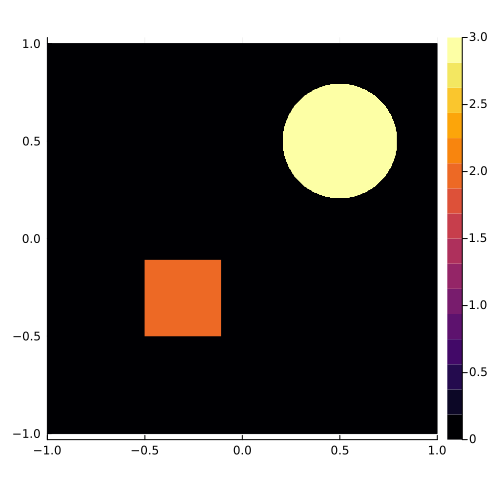

In [18]:
plt=contourf(x, y, lnperm',size=(500,500),aspect_ratio=:equal)
savefig(plt,"permittivity.png")
display(plt)

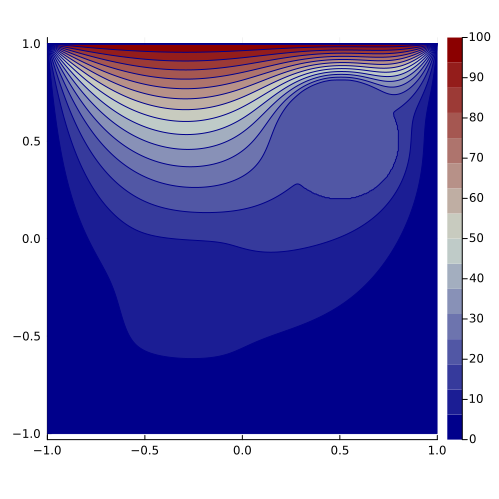

In [17]:
plt = contourf(x, y, V',size=(500,500),aspect_ratio=:equal,c=:bluesreds)
savefig(plt,"potential.png")
display(plt)

In [9]:
Ex = similar(V)
Ey = similar(V)
Exr = similar(V)
Eyr = similar(V)
calE!(Ex, Ey, V, dx, dy);
calE!(Exr, Eyr, V, dx, dy, rescale=true, scale=0.1);

In [10]:
zx = similar(V)
zy = similar(V)
nx,ny = size(V)
for j = 1:ny
    for i = 1:nx
        zx[i,j] = x[i]
        zy[i,j] = y[j]
    end
end
tf=20
zxt = thindata(zx,tf)
zyt = thindata(zy,tf)
Ext = thindata(Ex,tf)
Eyt = thindata(Ey,tf)
Exrt = thindata(Exr,tf)
Eyrt = thindata(Eyr,tf)
En = vectorFieldNorm(Ex, Ey)
@. En = log10(En)
xt = zxt[:,1]
yt = zyt[1,:];

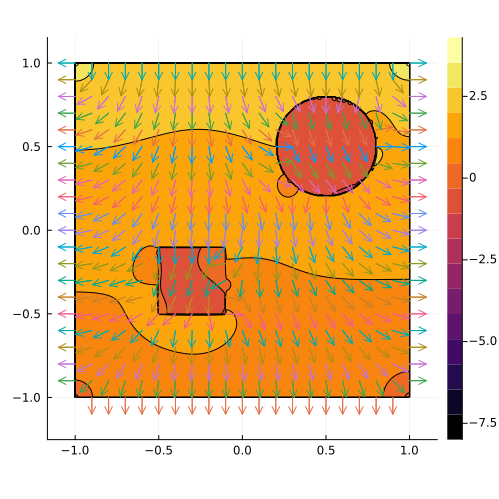

In [16]:
contourf(x, y, En', size=(500,500), aspect_ratio=:equal)
plt=quiver!(zxt, zyt, quiver=(Exrt,Eyrt))
savefig(plt,"electricfield.png")
display(plt)